# Coffee Review Cleaning and EDA

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_columns', 50)


df = pd.read_csv('data/raw_roast_reviews.csv')
df.sample(1)

df.head()


,Roaster Location:,Coffee Origin:,Roast Level:,Agtron:,Est. Price:,Review Date:,Aroma:,Acidity/Structure:,Body:,Flavor:,Aftertaste:,rating,roaster,name,url,With Milk:,Acidity:
0,"Taipei, Taiwan",Colombia; Ethiopia; Brazil,Medium,46/60,NT $420/454 grams,September 2023,8,8.0,9\t\t\t\t\t\t,8,7.0,90,Coffeebox Coffee,Big Mouth Frog Blend,https://www.coffeereview.com/review/big-mouth-...,NaN,NaN
1,"Hilo, Hawaii","Ka‘ū and Kona growing regions, Big Island of H...",Medium-Light,52/70,$20.00/4 ounces,September 2023,9,NaN,9\t\t\t\t\t\t,9,8.0,94,Paradise Roasters,Hawai’i Island Blend Espresso,https://www.coffeereview.com/review/hawaii-isl...,9,NaN
2,"Chicago, Illinois","Pichincha, Ecuador",Medium-Light,61/77,$62.00/8 ounces,August 2023,9,8.0,9\t\t\t\t\t\t,9,8.0,93,Big Shoulders Coffee,Ecuador Maputo Honey,https://www.coffeereview.com/review/ecuador-ma...,NaN,NaN
3,"Zhubei, Taiwan",Guatemala; Indonesia; Ethiopia,Medium-Light,58/74,NT $450/16 ounces,September 2023,8,NaN,8\t\t\t\t\t\t,9,8.0,92,Kafe Coffee Roastery,Vanilla Cocoa 2.0 Espresso,https://www.coffeereview.com/review/vanilla-co...,9,NaN
4,"Taichung, Taiwan","Boquete growing region, Panama",Light,65/81,NT $450/227 grams,August 2023,9,9.0,9\t\t\t\t\t\t,9,9.0,95,Lee Dong Coffee,Panama Florsa 100 Geisha FW 1600+,https://www.coffeereview.com/review/panama-flo...,NaN,NaN


In [25]:
def tweak_coffee(df):
    return (df
        .rename(columns = lambda c: c.replace(' ', '_'))
        .rename(columns = lambda c: c.replace(':', ''))
        .rename(columns = lambda c: c.lower().strip())
        .rename({'name': 'roast_name'})
        .drop_duplicates(subset=['roaster', 'name'])
        .assign(Review_Date = pd.to_datetime(#df['review_date'], format='%b %Y'),
                Acidity = lambda df_: df_['acidity/structure'].fillna(df_['Acidity']),
                Agtron_External = lambda df_: df_['agtron'].str.split('/', expand=True)[0],
                Agtron_Ground = lambda df_: df_['agtron'].str.split('/', expand=True)[1],
                Amount = lambda df_: df_['price'].str.split('/', expand=True)[1],
                Price = lambda df_: df_['price'].str.replace(',', '').str.split('/', expand=True)[0],)
    )
        
roasts = tweak_coffee(df)

roasts.head()

SyntaxError: invalid syntax (3608387294.py, line 10)

In [12]:
def split_price_currency(df):
    """Split Price column into a column of the value and the currency"""
    currency_pattern = r'\$?(\d+\.\d+|\d+)'
    price = df['Price']
    df['Price'] = price.apply(lambda x: re.search(currency_pattern, str(x)).group(1) if re.search(currency_pattern, str(x)) else None)
    df['Currency'] = price.apply(lambda x: re.sub(currency_pattern, '', str(x)) if re.search(currency_pattern, str(x)) else str(x)).str.strip()
    return df

def currency_clean(df):
    """Transform currency symbols to ISO 4217 codes, and clean up"""
    
    curr_map = {'#': 'GBP', '£':'GBP', '¥': 'CNY', '':'USD', 'pesos':'MXN', 'RMB':'CNY'}
    
    df.loc[(df['Currency'] == '$') | (df['Currency'].str.lower().str.contains('us', na=False)), 'Currency'] = 'USD'
    df.loc[df['Currency'].str.lower().str.contains('nt', na=False), 'Currency'] = 'TWD'
    df['Currency'] = (df['Currency']
                      .str.replace('$', '')
                      .replace(curr_map)
                      .str.strip()
                     )
    return df

def create_quantity_and_units(df):
    """Separate Amount column into a quantity and the units for that quantity. Then 
       converts all quantities to grams."""
    
    amount_pat = r'([\d.]+)\s*([a-zA-Z]+)'
    currency_pattern = r'(\d+\.\d+)'

    def convert_to_grams(df):
        POUND_TO_GRAM = 453.59
        OUNCE_TO_GRAM = 28.3495
        
        df.loc[df['Unit'] == 'ounces', 'Quantity'] = df['Quantity'] * OUNCE_TO_GRAM
        df.loc[df['Unit'] == 'pounds', 'Quantity'] = df['Quantity'] * POUND_TO_GRAM
        df['Unit'] = 'grams'
        
        return df
                        
    return (df
            .assign(Quantity = df['Amount'].str.extract(amount_pat)[0],
                     Unit = df['Amount'].str.extract(amount_pat)[1],
                    )
            .drop('Amount', axis=1)
            .astype({'Quantity': 'float'})
            .pipe(convert_to_grams)
            .dropna(subset=['Quantity'])
            )

def create_price_USD(df):
    """Create a column converting all prices to USD using recent exchange rates."""
    exchange_rate_map = {'TWD' : 0.03, 
                         'CNY': 0.03, 
                         'GBP': 1.27, 
                         'AED':0.27, 
                         'KRW': 0.000752,
                         'HKD':0.13, 
                         'CAD': 0.74,
                         'MXN': 0.06,
                         'IDR': 0.000065,
                         'AUD': 0.65,
                         'USD': 1.0}
    df['Price_USD'] = np.round(df['Price'] * df['Currency'].map(exchange_rate_map), 2)
    return df

def tweak_coffee(df):
    return (df
            .rename(columns = lambda c: c.replace(' ', '_'))
            .rename(columns = lambda c: c.replace(':', '').capitalize())
            .rename(columns = {'Coffee_Origin': 'Origin', 'Est._Price': 'Price', 'name':'Name'})
            .drop_duplicates(subset=['Roaster', 'Name'])
            .assign(Review_Date = pd.to_datetime(df['Review_Date'], format='%b %Y'),
                    Acidity = lambda df_: df_['Acidity/Structure'].fillna(df_['Acidity']),
                    Agtron_External = lambda df_: df_['Agtron'].str.split('/', expand=True)[0],
                    Agtron_Ground = lambda df_: df_['Agtron'].str.split('/', expand=True)[1],
                    Amount = lambda df_: df_['Price'].str.split('/', expand=True)[1],
                    Price = lambda df_: df_['Price'].str.replace(',', '').str.split('/', expand=True)[0],
                     )
            # Remove whitespace and tranform "NA" to NaN
            .applymap(lambda x: x.strip() if isinstance(x, str) else x)
            .applymap(lambda x: np.nan if x == 'NA' else x)
            .pipe(split_price_currency)
            .pipe(currency_clean)
            .drop(['Acidity/Structure', 'Agtron',], axis=1)
            .dropna(subset=['Acidity', 'Roast_Level', 'Aroma', 'Price', 'Bottom_Line', 
                            'Agtron_External', 'Agtron_Ground',])
            .pipe(create_quantity_and_units)
            .astype({'Roaster': 'category', 'Rating': 'int64', 'Roast_Level':'category',
                     'Aftertaste': 'int64', 'Aroma': 'int64', 'Body': 'int64',
                     'Flavor': 'int64', 'Currency':'category', 'Acidity': 'int64',
                     'Agtron_External': 'int64', 'Agtron_Ground':'int64', 'Price':'float',
                    'Unit': 'category'}
                   )
            .pipe(create_price_USD)
            # Agtron values must fall between 0 and 100. These values were incorrect from the source.
            .query('Agtron_External <= 100 and Agtron_Ground <= 100')
            .assign(Price_USD_Per_G = lambda df_: np.round(df_['Price_USD']/df_['Quantity'], 2))
            .reset_index(drop=True)
           ) 

coffee = tweak_coffee(df)
coffee.to_csv('data/coffee-reviews-clean.csv')
coffee.head()

KeyError: 'Review_Date'

In [4]:
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 
             'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
             'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 
             'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 
             'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 
             'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
             'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 
             'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 
             'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
             'West Virginia', 'Wisconsin','Wyoming']

canadian_provinces = ["Alberta","British Columbia", "Manitoba","New Brunswick", 
                      "Newfoundland and Labrador", "Nova Scotia", "Ontario",
                      "Prince Edward Island", "Quebec", "Saskatchewan",
                      "Northwest Territories","Nunavut","Yukon"]

us_states = [s.lower() for s in us_states]
canadian_provinces = [p.lower() for p in canadian_provinces]   

# Process roaster location by splitting city, state, and country into their own columns.
# Fix typos and standardize.
locations = (coffee['Roaster_Location']
             .str.strip()
             .str.lower()
             .str.replace("’", "")
             .str.replace("'", "")
             .str.split(',', expand=True)
             .apply(lambda row: row.str.strip())
             .replace({'californiaa': 'california', 'calfornia': 'california',
                       'washingto': 'washington', 'virginia and floyd': 'virginia'})
            )

# Cleaning up typos and other small idiosyncracies
locations.loc[locations[0] == "branford connecticut", 1] = "connecticut"
locations.loc[locations[0] == "los angeles", 1] = "california"
locations.loc[locations[1] == 'd.c.', [1, 2]] = ['district of columbia', 'usa']
locations[2] = locations[2].fillna(locations[1])
locations.loc[locations[2].str.contains('hawaii'), 1] = 'hawaii'
locations.loc[locations[1].isin(us_states),2 ]= 'usa'
locations.loc[locations[1].isin(canadian_provinces), 2] = 'canada'
locations[1] = locations[1].where(~(locations[1] == locations[2]), np.nan)
locations = locations.rename({0:'roaster_city', 1:'roaster_state', 2:'roaster_country'}, axis='columns')

coffee = pd.concat([coffee, locations], axis=1)
coffee.head()

,Rating,Roaster,Coffee_Name,Review_Date,Review_Description,Complete_Review_URL,Roaster_Website_URL,Roaster_Location,Origin,Roast_Level,Aroma,Acidity,Body,Flavor,Aftertaste,Blind_Assessment,Notes,Bottom_Line,Price,url,Agtron_External,Agtron_Ground,Currency,Quantity,Unit,Price_USD,Price_USD_Per_G,roaster_city,roaster_state,roaster_country
0,94,JBC Coffee Roasters,Wilton Benitez Sidra,2023-08-01,"Delicately fruity, richly floral-toned. Froot ...",https://www.coffeereview.com/review/wilton-ben...,https://www.jbccoffeeroasters.com/product-cate...,"Madison, Wisconsin","Piendamó, Cauca Department, Colombia",Medium-Light,9,9,9,9,8,"Delicately fruity, richly floral-toned. Froot ...","Produced by Wilton Benitez, entirely of the Si...","A complex, deep-toned, very fruit-forward anae...",22.0,https://www.coffeereview.com/review/wilton-ben...,58,74,USD,226.796,grams,22.0,0.10,madison,wisconsin,usa
1,92,JBC Coffee Roasters,Piura Peru,2023-08-01,Sweetly chocolaty and nut-toned. Baking chocol...,https://www.coffeereview.com/review/piura-peru/,https://www.jbccoffeeroasters.com/product-cate...,"Madison, Wisconsin","El Faique, Piura Department, Peru",Medium-Light,8,8,9,9,8,Sweetly chocolaty and nut-toned. Baking chocol...,Produced by smallholding farmers who work dire...,"A confident, deep-toned Peru with a chocolate-...",18.0,https://www.coffeereview.com/review/piura-peru/,56,74,USD,340.194,grams,18.0,0.05,madison,wisconsin,usa
2,95,Euphora Coffee,Panama Hacienda La Esmeralda Geisha Natural,2023-08-01,"Richly fruity, deeply chocolaty. Dark chocolat...",https://www.coffeereview.com/review/panama-hac...,https://www.euphoracoffeestudio.com/categories...,"Taipei, Taiwan","Boquete growing region, western Panama",Medium-Light,9,9,9,10,8,"Richly fruity, deeply chocolaty. Dark chocolat...","Produced at Hacienda La Esmeralda, entirely of...","Fruit, chocolate and floral notes converge in ...",22.0,https://www.coffeereview.com/review/panama-hac...,60,77,USD,113.398,grams,22.0,0.19,taipei,NaN,taiwan
3,95,Euphora Coffee,Panama Hacienda La Esmeralda Geisha Washed,2023-08-01,"High-toned, juicy-sweet. Lemongrass, cocoa nib...",https://www.coffeereview.com/review/panama-hac...,https://www.euphoracoffeestudio.com/categories...,"Taipei, Taiwan","Boquete growing region, western Panama",Light,9,9,9,9,9,"High-toned, juicy-sweet. Lemongrass, cocoa nib...","Produced at Hacienda La Esmeralda, entirely of...","Elegantly spice-toned, richly floral, complex ...",20.0,https://www.coffeereview.com/review/panama-hac...,64,78,USD,113.398,grams,20.0,0.18,taipei,NaN,taiwan
4,96,Rusty's Hawaiian,Grand Champion Red Bourbon Natural,2023-08-01,"Delicately fruit-forward, richly aromatic. Lyc...",https://www.coffeereview.com/review/grand-cham...,NaN,"Pahala, Hawaii","Ka'u growing district, Big Island of Hawai’i",Medium-Light,9,9,9,10,9,"Delicately fruit-forward, richly aromatic. Lyc...",This 100% Ka’u coffee was developed by Lorie O...,"This decadently sweet, elegantly tart, complex...",35.0,https://www.coffeereview.com/review/grand-cham...,52,72,USD,113.398,grams,35.0,0.31,pahala,hawaii,usa


In [5]:
# Cleaning up coffee origin location. 
origin = (coffee["Origin"]
 .str.split(',').str[-1]
 .str.lower()
 .str.strip()
 .str.replace(r'[-"‘\'.\“\”\’]', '', regex=True)
 .str.replace('southern', '')
 .str.replace('south-central', '')
 .str.replace('western', '')
 .str.replace('southwest', '')
 .str.replace('central', '')
 .str.replace('northern', '')
 .str.replace('eastern', '')
 .str.replace('southern', '')
 .str.replace('south', '')
 .str.replace('north', '')
 .str.replace('west', '')
 .str.replace('east', '')
 .str.replace('far', '')
 .str.replace('papua', '')
 .str.replace('the', '')
 .str.strip()
)

origin.loc[origin.str.contains(';')] = 'multiple'
origin.loc[origin.str.contains('hawaii')] = 'hawaii'
origin.loc[origin.str.contains('ethiopia')] = 'ethiopia'
origin.loc[origin.str.contains('congo')] = 'democratic republic of the congo'
origin.loc[origin.str.contains('apaneca')] = 'el salvador'
origin.loc[origin.str.contains('sumatra')] = 'sumatra'
origin.loc[origin.str.contains('colombia')] = 'colombia'
origin = origin.replace({'america':'usa', '': np.nan, 'gedeo zone':'ethiopia',
                         'coastal california':'usa'})

coffee['Origin'] = origin
coffee.head()

,Rating,Roaster,Coffee_Name,Review_Date,Review_Description,Complete_Review_URL,Roaster_Website_URL,Roaster_Location,Origin,Roast_Level,Aroma,Acidity,Body,Flavor,Aftertaste,Blind_Assessment,Notes,Bottom_Line,Price,url,Agtron_External,Agtron_Ground,Currency,Quantity,Unit,Price_USD,Price_USD_Per_G,roaster_city,roaster_state,roaster_country
0,94,JBC Coffee Roasters,Wilton Benitez Sidra,2023-08-01,"Delicately fruity, richly floral-toned. Froot ...",https://www.coffeereview.com/review/wilton-ben...,https://www.jbccoffeeroasters.com/product-cate...,"Madison, Wisconsin",colombia,Medium-Light,9,9,9,9,8,"Delicately fruity, richly floral-toned. Froot ...","Produced by Wilton Benitez, entirely of the Si...","A complex, deep-toned, very fruit-forward anae...",22.0,https://www.coffeereview.com/review/wilton-ben...,58,74,USD,226.796,grams,22.0,0.10,madison,wisconsin,usa
1,92,JBC Coffee Roasters,Piura Peru,2023-08-01,Sweetly chocolaty and nut-toned. Baking chocol...,https://www.coffeereview.com/review/piura-peru/,https://www.jbccoffeeroasters.com/product-cate...,"Madison, Wisconsin",peru,Medium-Light,8,8,9,9,8,Sweetly chocolaty and nut-toned. Baking chocol...,Produced by smallholding farmers who work dire...,"A confident, deep-toned Peru with a chocolate-...",18.0,https://www.coffeereview.com/review/piura-peru/,56,74,USD,340.194,grams,18.0,0.05,madison,wisconsin,usa
2,95,Euphora Coffee,Panama Hacienda La Esmeralda Geisha Natural,2023-08-01,"Richly fruity, deeply chocolaty. Dark chocolat...",https://www.coffeereview.com/review/panama-hac...,https://www.euphoracoffeestudio.com/categories...,"Taipei, Taiwan",panama,Medium-Light,9,9,9,10,8,"Richly fruity, deeply chocolaty. Dark chocolat...","Produced at Hacienda La Esmeralda, entirely of...","Fruit, chocolate and floral notes converge in ...",22.0,https://www.coffeereview.com/review/panama-hac...,60,77,USD,113.398,grams,22.0,0.19,taipei,NaN,taiwan
3,95,Euphora Coffee,Panama Hacienda La Esmeralda Geisha Washed,2023-08-01,"High-toned, juicy-sweet. Lemongrass, cocoa nib...",https://www.coffeereview.com/review/panama-hac...,https://www.euphoracoffeestudio.com/categories...,"Taipei, Taiwan",panama,Light,9,9,9,9,9,"High-toned, juicy-sweet. Lemongrass, cocoa nib...","Produced at Hacienda La Esmeralda, entirely of...","Elegantly spice-toned, richly floral, complex ...",20.0,https://www.coffeereview.com/review/panama-hac...,64,78,USD,113.398,grams,20.0,0.18,taipei,NaN,taiwan
4,96,Rusty's Hawaiian,Grand Champion Red Bourbon Natural,2023-08-01,"Delicately fruit-forward, richly aromatic. Lyc...",https://www.coffeereview.com/review/grand-cham...,NaN,"Pahala, Hawaii",hawaii,Medium-Light,9,9,9,10,9,"Delicately fruit-forward, richly aromatic. Lyc...",This 100% Ka’u coffee was developed by Lorie O...,"This decadently sweet, elegantly tart, complex...",35.0,https://www.coffeereview.com/review/grand-cham...,52,72,USD,113.398,grams,35.0,0.31,pahala,hawaii,usa


Summary Statistics:

Calculate basic statistics like mean, median, and standard deviation for the 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste,' and 'Price' columns to get an overall understanding of the dataset.
Correlation Analysis:

Investigate the correlations between different attributes such as 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste.' This can help identify which attributes tend to go together or have an impact on the overall rating.
Distribution Analysis:

Visualize the distributions of 'Rating,' 'Aroma,' 'Acidity,' 'Body,' 'Flavor,' and 'Aftertaste' using histograms or box plots to understand the spread of values.
Top Roasters and Coffees:

Identify the top-rated roasters and coffee names based on the 'Rating' column. This can help consumers find highly-rated options.
Time-Series Analysis:

If you have data for multiple years, analyze trends in coffee ratings over time. Are there any patterns or changes in preferences?
Geospatial Analysis:

Analyze the 'Roaster_Location' and 'Origin' columns to understand where the roasters are located and where the coffee beans are sourced from. You can use geospatial tools to create maps or investigate the relationship between origin and rating.
Currency Analysis:

Analyze the 'Currency' column to understand the currencies used for pricing. You can convert prices to a common currency (e.g., USD) for comparison.
Price Analysis:

Analyze the relationship between 'Price' and 'Rating.' Do higher-priced coffees tend to have higher ratings? You can also look for outliers in pricing.
Text Analysis:

Perform natural language processing (NLP) on the 'Review_Description,' 'Blind_Assessment,' and 'Notes' columns to extract insights about the sensory descriptions, flavor profiles, and unique characteristics of the coffees.
Website Analysis:

Analyze the 'Roaster_Website_URL' to explore which roasters have a strong online presence and whether this correlates with higher ratings or prices.
Quantity Analysis:

Investigate the 'Quantity' and 'Unit' columns to understand the different packaging sizes and units in which coffee is sold. Analyze how these factors relate to pricing and consumer preferences.
External Metrics:

Explore the 'Agtron_External' and 'Agtron_Ground' columns, which may contain external metrics related to coffee quality. Analyze how these metrics correlate with sensory ratings.
Market Basket Analysis:

Explore which attributes (e.g., 'Aroma,' 'Acidity,' 'Body,' 'Flavor') tend to co-occur in coffee reviews. This can help identify flavor profiles that are popular among consumers.
Pricing Strategy:

Investigate the relationship between pricing ('Price' and 'Currency') and sensory attributes ('Aroma,' 'Acidity,' 'Body,' 'Flavor,' 'Aftertaste'). Are there pricing strategies associated with higher ratings?
Consumer Segmentation:

Segment consumers based on their preferences and ratings. Are there distinct groups of consumers with similar taste profiles?
Roaster Performance:

Evaluate roasters' performance based on their ratings and the origin of the coffee beans. Are there specific regions or origins associated with higher ratings for particular roasters?
URL Analysis:

Analyze the 'Complete_Review_URL' and 'Roaster_Website_URL' columns for insights into the sources of reviews and roaster websites' availability and quality.
Remember that the choice of analysis depends on your specific objectives and questions you want to answer. Combining several of these analyses can provide a comprehensive understanding of the dataset and valuable insights for both consumers and coffee businesses.

### EDA ideas
- visualize histograms
- visualize correlations
- word clouds
- tokenize descriptions
- plot locations, roasters, roast level, agtron vs other characterisitcs
- cluster analysis
- standardize ratings?? 



In [15]:
num_vars = (coffee
                .select_dtypes(include='number')
                .drop(['Price', 'Price_USD', 'Quantity'], axis='columns')
            )

num_vars.describe()


,Rating,Aroma,Acidity,Body,Flavor,Aftertaste,Agtron_External,Agtron_Ground,Price_USD_Per_G
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,93.132172,8.863217,8.532787,8.642418,8.986168,8.108607,57.289447,75.765369,0.111296
std,1.585089,0.392445,0.549871,0.497254,0.319073,0.478645,4.968144,6.044790,0.276073
min,84.000000,7.000000,6.000000,7.000000,7.000000,6.000000,32.000000,40.000000,0.010000
25%,92.000000,9.000000,8.000000,8.000000,9.000000,8.000000,55.000000,74.000000,0.050000
50%,93.000000,9.000000,9.000000,9.000000,9.000000,8.000000,58.000000,77.000000,0.060000
75%,94.000000,9.000000,9.000000,9.000000,9.000000,8.000000,60.000000,79.000000,0.090000
max,98.000000,10.000000,10.000000,10.000000,10.000000,9.000000,79.000000,99.000000,7.500000


<Axes: >

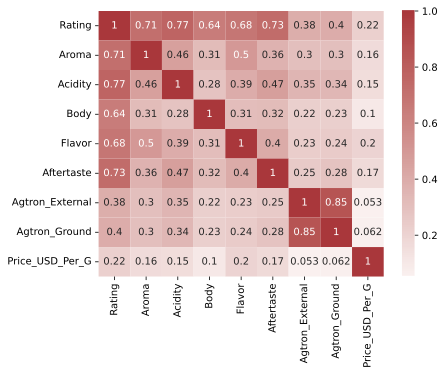

In [57]:
sns.heatmap(num_vars.corr(), cmap='vlag', center=0, annot=True)

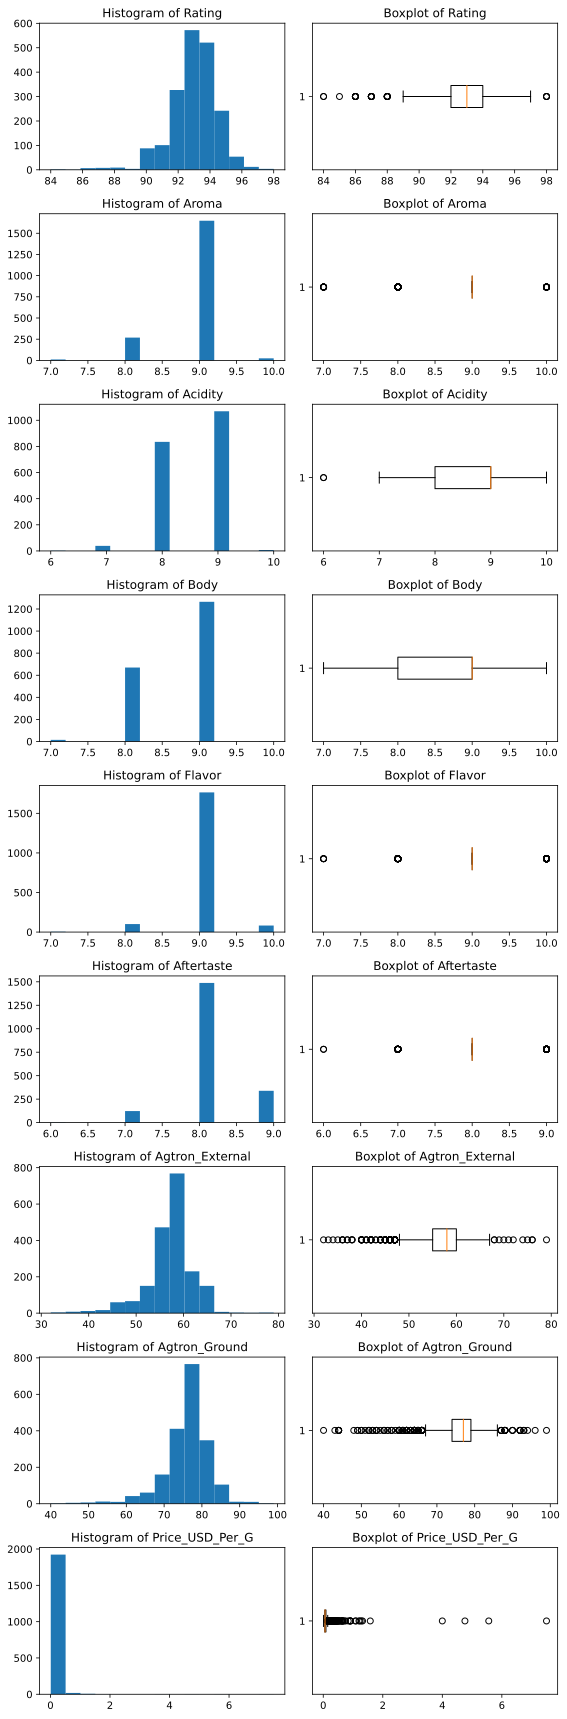

In [58]:
fig, axes = plt.subplots(len(num_vars.columns), 2, figsize=(8, 24), sharex=False)

for i, col in enumerate(num_vars.columns):
    
    data = num_vars[col]
    ax1 = axes[i, 0]
    ax1.hist(data, bins=15)
    ax1.set_title("Histogram of {}".format(col))
    
    ax2 = axes[i, 1]
    ax2.boxplot(data, vert=False)
    ax2.set_title("Boxplot of {}".format(col))
plt.tight_layout()
plt.show()

In [43]:
log_price_per_g = np.log(coffee['Price_USD_Per_G'])

<Axes: >

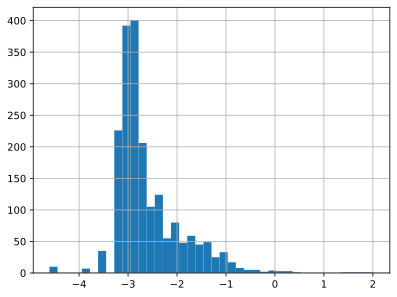

In [59]:
log_price_per_g.hist(bins=40)

<Axes: >

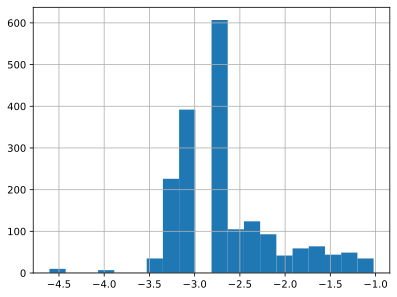

In [60]:
log_price_per_g[log_price_per_g < -1].hist(bins=20)